# 1. Import Libraries

In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [357]:
df = pd.read_csv("teleComm.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


 # EDA (Exploratory Data Analysis) + Data Cleaning

In [358]:
df.shape

(7043, 21)

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [360]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [361]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [362]:
df.duplicated().sum()

np.int64(0)

## lets see some basic plots

### Count plot of Churn

Text(0.5, 1.0, 'Churn Count')

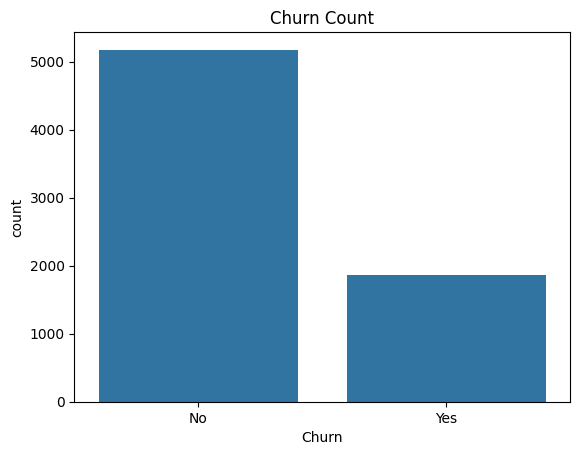

In [363]:
sns.countplot(x='Churn', data=df)
plt.title("Churn Count")

### Count plot of gender

Text(0.5, 1.0, 'Gender Distribution')

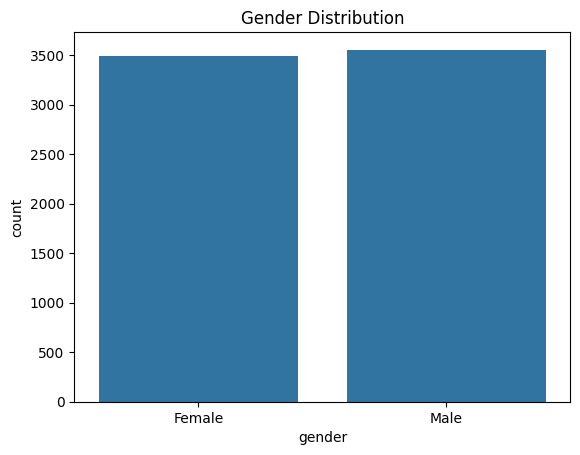

In [364]:
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")

### Histogram of Monthly Charges

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

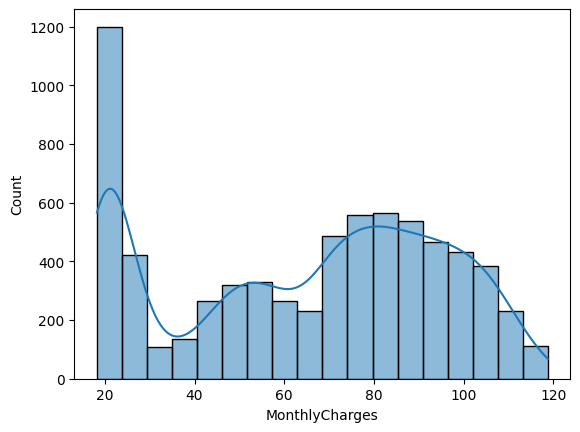

In [365]:
sns.histplot(df['MonthlyCharges'], kde=True)

### Histogram of Tenure

<Axes: xlabel='tenure', ylabel='Count'>

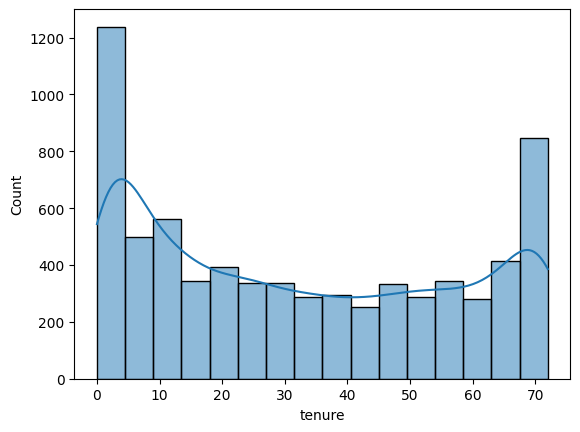

In [366]:
sns.histplot(df['tenure'], kde=True)

### Boxplot of MonthlyCharges (by Churn)

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

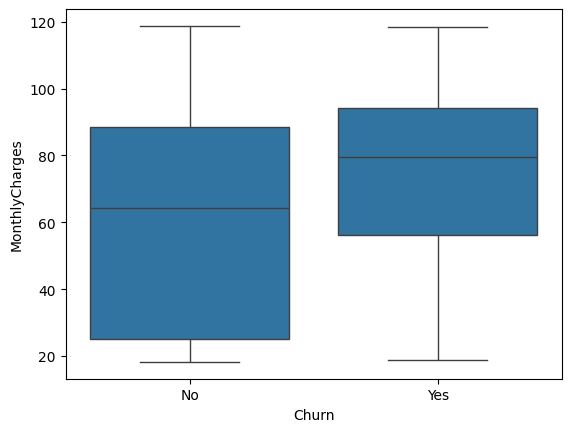

In [367]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)

### Correlation heatmap (simple)

<Axes: >

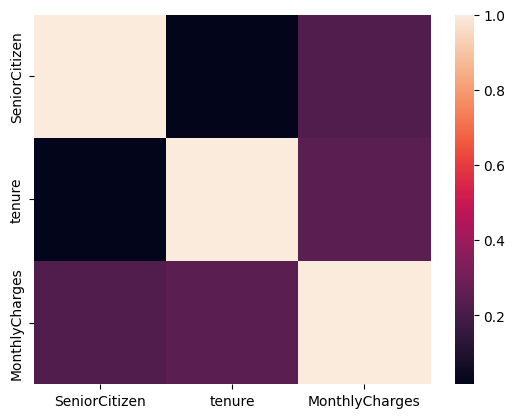

In [368]:
sns.heatmap(df.select_dtypes(include=['int64','float64']).corr())

### Countplot for Contract type

<Axes: xlabel='Contract', ylabel='count'>

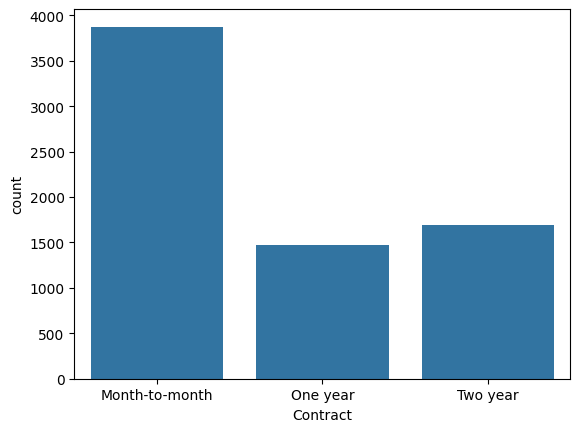

In [369]:
sns.countplot(x='Contract', data=df)

# OUTLIER REMOVAL (IQR METHOD)

In [370]:
num_cols = df.select_dtypes(include=['number']).columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier boundaries
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("Shape after removing outliers:", df.shape)

Shape after removing outliers: (5901, 21)


# 3. Hypothesis Tests — quick & friendly

In [371]:
from scipy.stats import ttest_ind, chi2_contingency

In [372]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if 'Churn' in num_cols: num_cols.remove('Churn')
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [373]:
num_pvals = {}
for c in num_cols:
    a = df[df['Churn']==0]
    b = df[df['Churn']==1]
    if len(a)>4 and len(b)>4:
        _, p = ttest_ind(a, b, equal_var=False)
        num_pvals[c] = p
    else:
        num_pvals[c] = None

cat_pvals = {}
for c in cat_cols:
    table = pd.crosstab(df[c].fillna("MISSING"), df['Churn'])
    if table.shape[1] < 3:
        _, p, _, _ = chi2_contingency(table)
        cat_pvals[c] = p
    else:
        cat_pvals[c] = None

print("Numeric p-values:\n", pd.Series(num_pvals).sort_values())
print("\nCategorical p-values:\n", pd.Series(cat_pvals).sort_values())


Numeric p-values:
 SeniorCitizen     None
tenure            None
MonthlyCharges    None
dtype: object

Categorical p-values:
 Churn                0.000000e+00
Contract            3.454811e-202
OnlineSecurity      1.440960e-148
TechSupport         3.658364e-139
InternetService     1.352830e-129
PaymentMethod       1.100647e-110
OnlineBackup        1.266693e-103
DeviceProtection     1.010179e-96
StreamingMovies      9.293938e-66
StreamingTV          9.772401e-65
PaperlessBilling     2.284731e-43
Partner              2.027578e-33
Dependents           9.962311e-29
MultipleLines        2.174030e-01
PhoneService         3.051395e-01
customerID           4.938795e-01
gender               5.727085e-01
TotalCharges         6.306235e-01
dtype: float64


#### Feature drop rule

In [374]:
alpha = 0.05
drop_list = []
for col, p in num_pvals.items():
    if p is None or p > alpha:
        drop_list.append(col)

for col, p in cat_pvals.items():
    if p is None or p > alpha:
        drop_list.append(col)

# remove duplicates
drop_list = list(set(drop_list))
drop_list


['PhoneService',
 'MonthlyCharges',
 'MultipleLines',
 'tenure',
 'SeniorCitizen',
 'TotalCharges',
 'customerID',
 'gender']

### drop highly correlated numeric among remaining


In [375]:
df = df.drop(columns=drop_list)
print("New shape:", df.shape)

New shape: (5901, 13)


# 4. Feature Engineering

In [376]:
from sklearn.preprocessing import LabelEncoder

In [377]:
le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5901 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Partner           5901 non-null   int64
 1   Dependents        5901 non-null   int64
 2   InternetService   5901 non-null   int64
 3   OnlineSecurity    5901 non-null   int64
 4   OnlineBackup      5901 non-null   int64
 5   DeviceProtection  5901 non-null   int64
 6   TechSupport       5901 non-null   int64
 7   StreamingTV       5901 non-null   int64
 8   StreamingMovies   5901 non-null   int64
 9   Contract          5901 non-null   int64
 10  PaperlessBilling  5901 non-null   int64
 11  PaymentMethod     5901 non-null   int64
 12  Churn             5901 non-null   int64
dtypes: int64(13)
memory usage: 645.4 KB


# 5. Train/Test Split

In [379]:
from sklearn.model_selection import train_test_split

In [380]:
X  = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### SCALE NUMERIC COLUMNS

In [381]:
from sklearn.preprocessing import StandardScaler

In [382]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

#  model Training

#### import all models annd define it

In [383]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [384]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier()
svm = SVC(probability=True, random_state=42)
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

#### models that need scaled data

In [385]:
scaled_models = [
    ("LogisticRegression", log_reg, X_train_scaled, X_test_scaled),
    ("KNN", knn, X_train_scaled, X_test_scaled),
    ("SVM", svm, X_train_scaled, X_test_scaled),
]

#### models that do NOT need scaling

In [386]:
unscaled_models = [
    ("DecisionTree", tree, X_train, X_test),
    ("RandomForest", rf, X_train, X_test),
]

#### train baseline Model

In [387]:
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [388]:
results = {}

In [389]:
for name, model, X_train, X_test in scaled_models + unscaled_models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results[name] = (model, f1, acc)
    print(f"{name:18s}  ACC: {acc:.3f} | F1: {f1:.3f}")

LogisticRegression  ACC: 0.807 | F1: 0.489
KNN                 ACC: 0.774 | F1: 0.438
SVM                 ACC: 0.796 | F1: 0.399
DecisionTree        ACC: 0.760 | F1: 0.433
RandomForest        ACC: 0.782 | F1: 0.476


## HYPERPARAMETER TUNING (VERY SMALL GRIDS)

In [390]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression tuning


In [391]:
lr_grid = {"C":[0.1, 1, 5]}
lr_gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                     lr_grid, scoring="f1",cv=2)
lr_gs.fit(X_train_scaled, y_train)
best_lr = lr_gs.best_estimator_
preds = best_lr.predict(X_test_scaled)
results["LogisticRegression_tuned"] = (best_lr, f1_score(y_test,preds), accuracy_score(y_test,preds))
print("Best LR params:", lr_gs.best_params_)

Best LR params: {'C': 5}


### KNN tuning

In [396]:
knn_grid = {"n_neighbors":[3,5,7], "weights":["uniform","distance"]}
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_grid, scoring="f1")
knn_gs.fit(X_train_scaled, y_train)
best_knn = knn_gs.best_estimator_
preds = best_knn.predict(X_test_scaled)
results["KNN_tuned"] = (best_knn, f1_score(y_test,preds), accuracy_score(y_test,preds))
print("Best KNN params:", knn_gs.best_params_)

Best KNN params: {}


### RandomForest tuning

In [393]:
rf_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[None,5,10],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[1,2,4]
}
rf_gs = GridSearchCV(RandomForestClassifier(random_state=42),
                     rf_grid, scoring="f1")
rf_gs.fit(X_train, y_train)
best_rf = rf_gs.best_estimator_
preds = best_rf.predict(X_test)
results["RF_tuned"] = (best_rf, f1_score(y_test,preds), accuracy_score(y_test,preds))
print("Best RF params:", rf_gs.best_params_)

Best RF params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


### SHOW ALL RESULTS CLEARLY

In [394]:
for name, (model, f1, acc) in results.items():
    print(f"{name:22s} | ACC: {acc:.3f} | F1: {f1:.3f}")

LogisticRegression     | ACC: 0.807 | F1: 0.489
KNN                    | ACC: 0.774 | F1: 0.438
SVM                    | ACC: 0.796 | F1: 0.399
DecisionTree           | ACC: 0.760 | F1: 0.433
RandomForest           | ACC: 0.782 | F1: 0.476
LogisticRegression_tuned | ACC: 0.806 | F1: 0.488
KNN_tuned              | ACC: 0.759 | F1: 0.438
RF_tuned               | ACC: 0.798 | F1: 0.471


### PICK BEST MODEL (highest F1)

In [395]:
best_name = max(results, key=lambda k: results[k][1])
best_model = results[best_name][0]
print("\nBEST MODEL SELECTED:", best_name)


BEST MODEL SELECTED: LogisticRegression


# save the model

In [397]:
import pickle

In [398]:
pickle.dump(best_model, open("model.pkl", "wb"))